In [86]:
# !pip install japanize-matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import scikit_posthocs as sp
import itertools
import numpy as np
import io
import japanize_matplotlib
from statsmodels.stats.contingency_tables import Table
from statannotations.Annotator import Annotator
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
timestamp = datetime.now().strftime('%Y%m%d')

## Analysis

In [93]:
df_final = pd.read_csv("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/data/df_final_dmft_Grade.csv", index_col=0)
df_final.columns 

Index(['No_All', 'CGC', 'date', 'sex', 'age_year', 'age_month', 'age',
       'abuse_1', 'abuse', 'abuse_num',
       ...
       'Present_Perm_Teeth', 'Present_Baby_Teeth', 'Healthy_Rate', 'C0_Count',
       'Care_Index', 'Trauma_Count', 'RDT_Count', 'UTN_Score', 'BirthDay',
       'Grade'],
      dtype='object', length=103)

#### Analysis for all

In [17]:
# Define the columns to analyze
columns_to_analyze = ['age_year', 'age', 'Perm_D', 'Perm_M', 'Perm_F', 'Baby_d', 
                      'Baby_m', 'Baby_f', 'Perm_DMFT', 'Baby_DMFT', 'Perm_DMFT_C0', 
                      'Baby_DMFT_C0', 'DMFT_Index', 'DMFT_C0','Present_Teeth', 'Present_Perm_Teeth', 
                      'Present_Baby_Teeth', 'Healthy_Rate', 'C0_Count', 'Care_Index', 
                      'Trauma_Count', 'RDT_Count', 'UTN_Score']

# Calculate statistics
stats_summary = df_final[columns_to_analyze].agg([
    'mean',
    'std',      # Standard Deviation
    'median',
    lambda x: x.quantile(0.25),  # 25th percentile
    lambda x: x.quantile(0.75),  # 75th percentile
    'min',
    'max'
]).T  # Transpose to have columns as rows

# Rename the lambda functions to readable names
stats_summary.columns = ['Mean', 'SD', 'Median', '25%', '75%', 'Min', 'Max']

# Round to 2 decimal places
stats_summary = stats_summary.round(2)

# Add a column with variable names (index as column)
stats_summary.insert(0, 'Variable', stats_summary.index)

# More comprehensive version with count
stats_summary = df_final[columns_to_analyze].describe(
    percentiles=[0.25, 0.75]
).T

# Rename columns for clarity
stats_summary = stats_summary.rename(columns={
    'std': 'SD',
    '50%': 'Median',
    'count': 'N'
})

# Select and reorder columns
stats_summary = stats_summary[['N', 'mean', 'SD', 'Median', '25%', '75%', 'min', 'max']]
stats_summary.columns = ['N', 'Mean', 'SD', 'Median', '25%', '75%', 'Min', 'Max']

# Round to 2 decimal places
stats_summary = stats_summary.round(2)

# Reset index to make variable name a column
stats_summary.insert(0, 'Variable', stats_summary.index)

# Display
# print(stats_summary.to_string(index=False))

# Save to CSV
output_path = f'/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_stats_{timestamp}.csv'
stats_summary.to_csv(output_path, index=False)
print(f"\n✓ Saved to: {output_path}")


✓ Saved to: /Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_stats_20251209.csv


##### for each abuse

In [18]:
# Wide format: Each abuse type as separate columns
all_abuse_stats = []

for abuse_type in df_final['abuse'].unique():
    subset = df_final[df_final['abuse'] == abuse_type]
    
    # Calculate stats
    stats = subset[columns_to_analyze].describe(percentiles=[0.25, 0.75]).T
    stats = stats[['count', 'mean', 'std', '50%', '25%', '75%', 'min', 'max']]
    stats.columns = ['N', 'Mean', 'SD', 'Median', '25%', '75%', 'Min', 'Max']
    stats = stats.round(2)
    
    # Add abuse type to column names
    stats.columns = [f"{abuse_type}_{col}" for col in stats.columns]
    all_abuse_stats.append(stats)

# Combine horizontally
wide_format = pd.concat(all_abuse_stats, axis=1)
wide_format.insert(0, 'Variable', wide_format.index)

# Save wide format
wide_path = '/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_stats_eachAbuse.csv'
wide_format.to_csv(wide_path, index=False)
print(f"✓ Wide format saved to: {wide_path}")

✓ Wide format saved to: /Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_stats_eachAbuse.csv


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Physical Abuse vs. Neglect: Mann-Whitney-Wilcoxon test two-sided, P_val:6.889e-04 U_stat=9.325e+04
Neglect vs. Emotional Abuse: Mann-Whitney-Wilcoxon test two-sided, P_val:4.208e-04 U_stat=3.839e+04


/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_69071/1252193957.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=18)


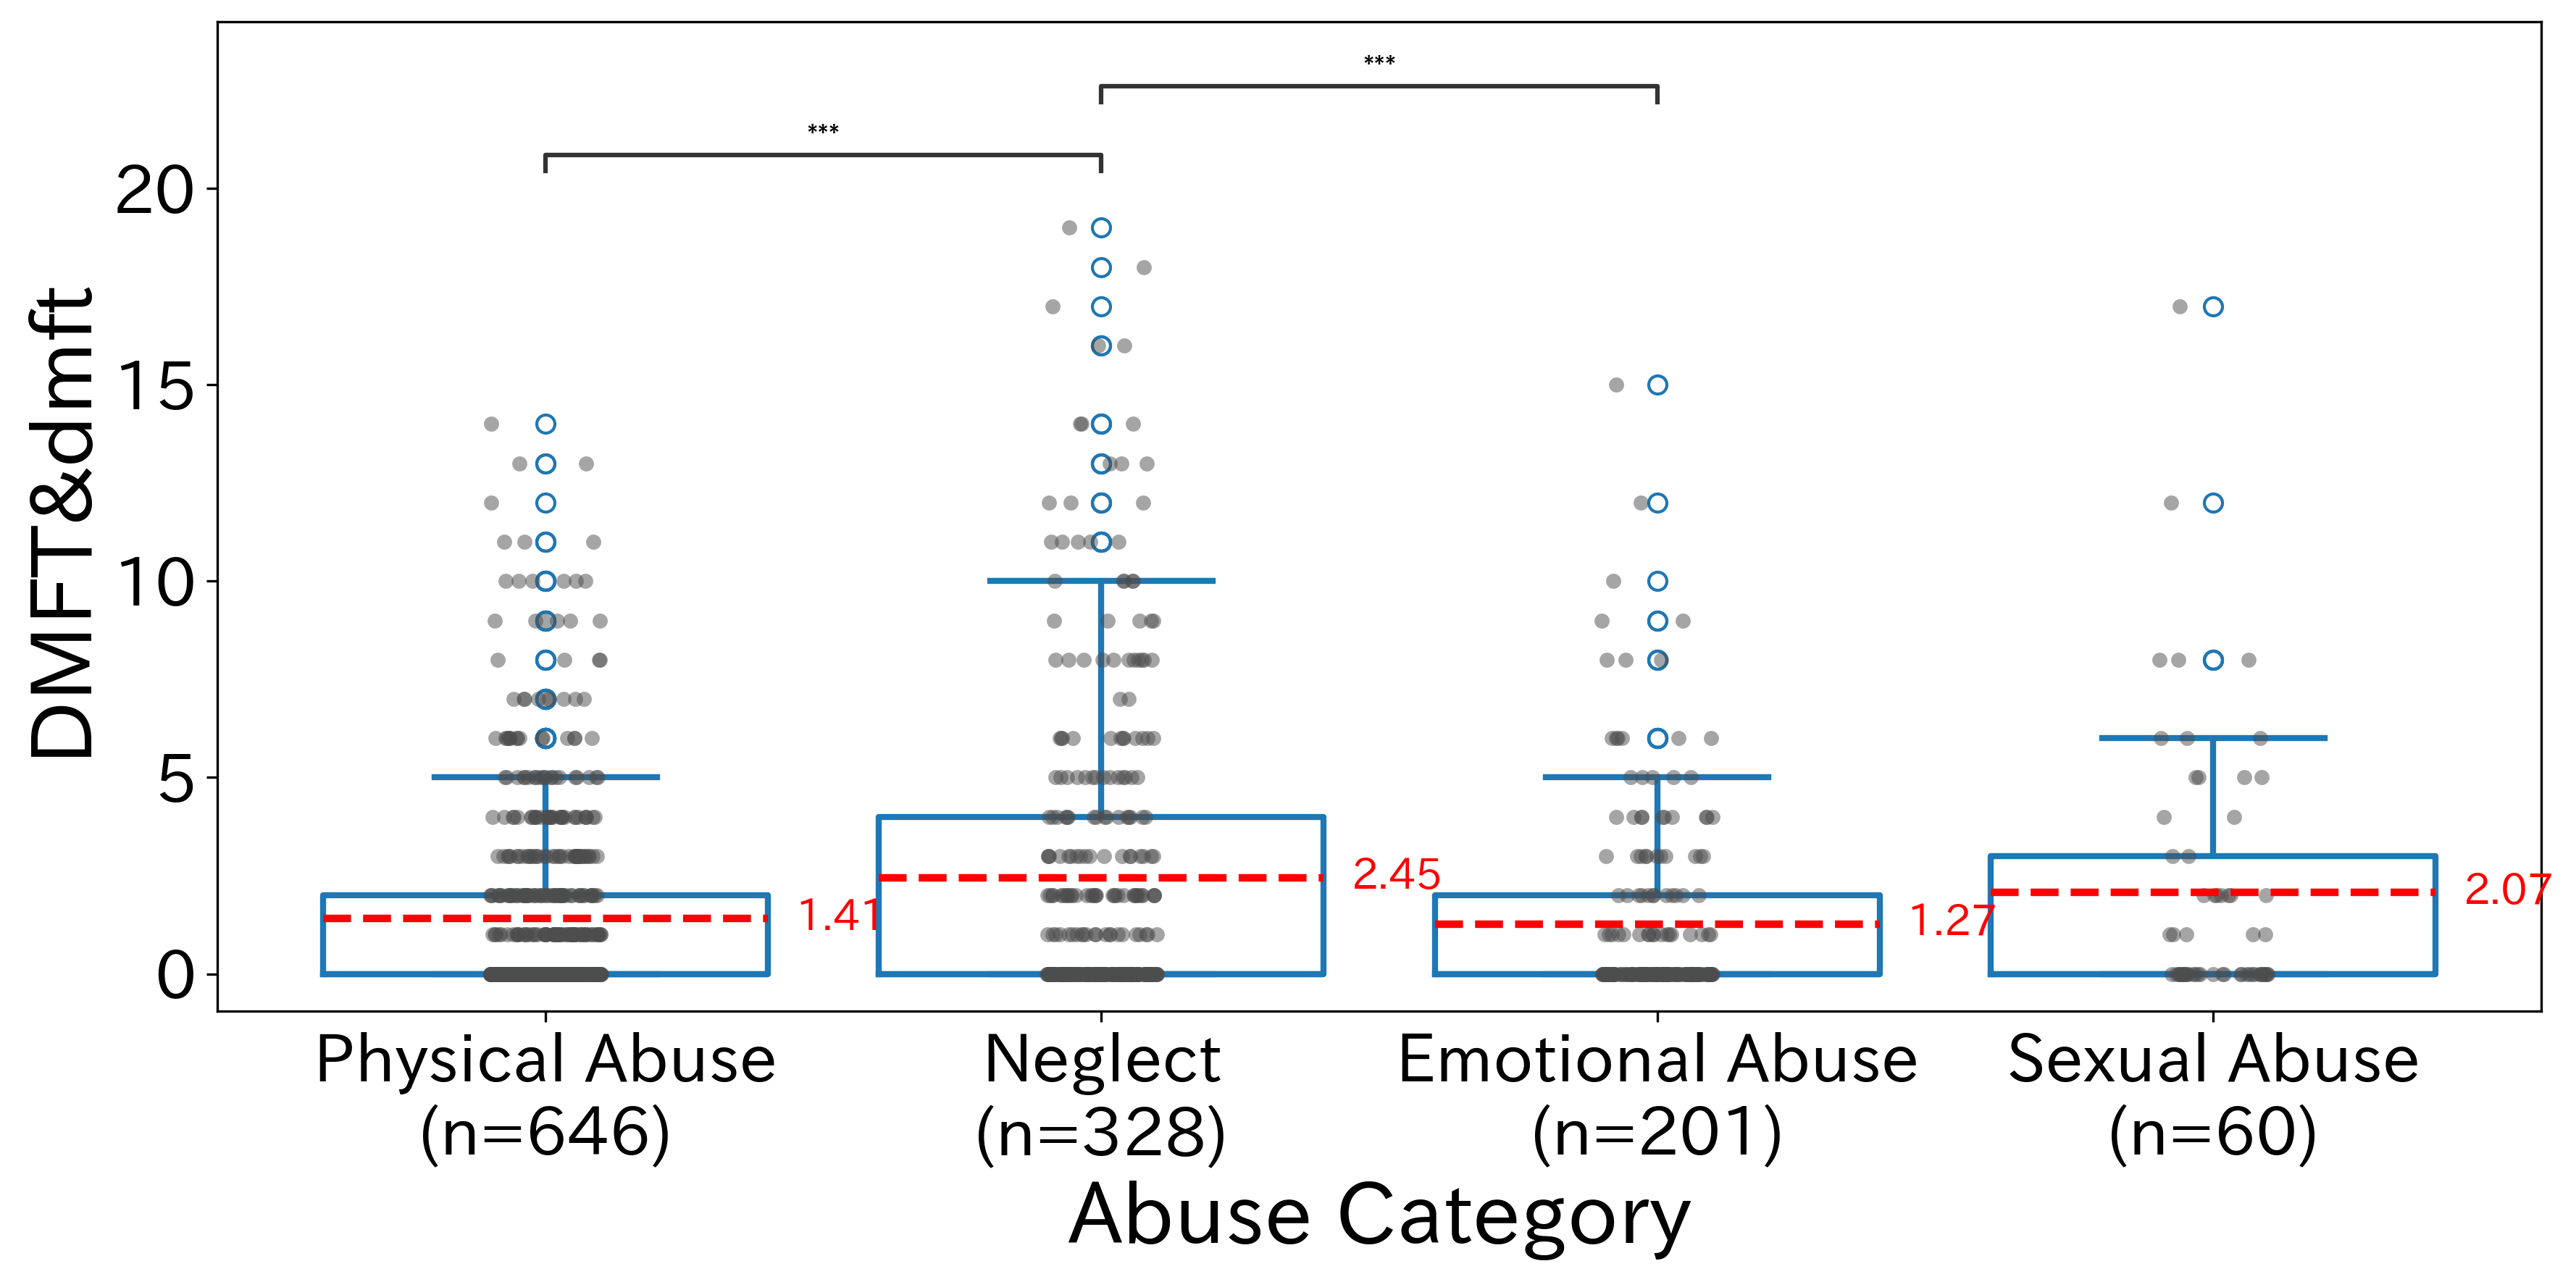

In [45]:
# --- 可視化設定 ---
plt.figure(figsize=(12, 6), dpi=300)

# 1. Boxplot (順序を指定: order=abuse_order)
abuse_order = ['Physical Abuse', 'Neglect', 'Emotional Abuse', 'Sexual Abuse']

ax = sns.boxplot(x='abuse', y='DMFT_Index', data=df_final, 
                order=abuse_order,
                 fill=False, legend=False, linewidth=2)

# 2. Stripplot (順序を指定: order=abuse_order)
sns.stripplot(x='abuse', y='DMFT_Index', data=df_final, order=abuse_order,
              jitter=True, alpha=0.5, size=5, color=".3")

# 全ての組み合わせのペアを作成
box_pairs = list(itertools.combinations(abuse_order, 2))

# 検定の実行と描画
annotator = Annotator(ax, box_pairs, data=df_final, x='abuse', y='DMFT_Index', order=abuse_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
# test='t-test_ind' (t検定) に変更可能
# text_format='simple' にすると "p=0.05" のように数値で表示 # star
annotator.apply_and_annotate()
# ---------------------------------------

# 3. Mean lines and annotations (平均値の線と数値)
# abuse_order を使ってループすることで位置ズレを防ぎます
for i, abuse_type in enumerate(abuse_order):
    subset = df_final[df_final['abuse'] == abuse_type]['DMFT_Index']
    mean_val = subset.mean()
    
    # Draw mean line
    ax.hlines(mean_val, i - 0.4, i + 0.4, colors='red', linestyles='--', linewidth=2.5, 
              label='Mean' if i == 0 else '', zorder=10)
    
    # Add mean value text
    ax.text(i + 0.45, mean_val, f'{mean_val:.2f}', fontsize=14, color='red', 
            va='center', fontweight='bold')


# 4. Add sample sizes to x-axis labels
# 現在のラベルを取得し、n数を追記
# 順序固定しているため、ラベル取得も安全に行えます
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [f'{label}\n(n={len(df_final[df_final["abuse"] == label])})' for label in labels]
ax.set_xticklabels(new_labels, fontsize=18)

# その他設定
labelSize= 22
ax.tick_params(axis='y', labelsize=labelSize)
ax.tick_params(axis='x', labelsize=labelSize)

FontSize = 28
plt.xlabel('Abuse Category', fontsize=FontSize, fontweight='bold')
plt.ylabel('DMFT&dmft', fontsize=FontSize, fontweight='bold')

plt.tight_layout()
plt.savefig("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/boxplot_DMFT_Index.tiff", dpi=300)

plt.show()

In [22]:
# 群間検定 (Kruskal-Wallis 検定)
# 各グループのデータをリストに格納
groups = [df_final[df_final['abuse'] == i]['DMFT_Index'] for i in df_final['abuse'].unique()]

# 検定実行
stat, p_value = stats.kruskal(*groups)

print(f"--- Kruskal-Wallis Test Results ---")
print(f"Statistic: {stat:.2f}")
print(f"P-value:   {p_value:.2e}")

if p_value < 0.05:
    print(">> 結果: 有意差あり (p < 0.05)。事後検定を行います。")
    
    # ==========================================
    # 4. 事後検定 (Dunn's Test with Bonferroni correction)
    # ==========================================
    # どの群間に差があるかを特定します
    # p_adjust='bonferroni' (ボンフェローニ補正) または 'holm' (ホルム補正) を推奨
    dunn_results = sp.posthoc_dunn(df_final, val_col='DMFT_Index', group_col='abuse', p_adjust='bonferroni')
    
    print("\n--- Dunn's Post-hoc Test (P-values) ---")
    print(dunn_results)
    
    # 見やすく判定を出力 (0.05以下ならTrue)
    print("\n--- Significant Differences (p < 0.05) ---")
    print(dunn_results < 0.05)
    
else:
    print(">> 結果: 有意差なし (p >= 0.05)。群間に統計的な差は見られませんでした。")

--- Kruskal-Wallis Test Results ---
Statistic: 17.38
P-value:   5.91e-04
>> 結果: 有意差あり (p < 0.05)。事後検定を行います。

--- Dunn's Post-hoc Test (P-values) ---
                 Emotional Abuse   Neglect  Physical Abuse  Sexual Abuse
Emotional Abuse         1.000000  0.001649        1.000000      0.415717
Neglect                 0.001649  1.000000        0.004184      1.000000
Physical Abuse          1.000000  0.004184        1.000000      1.000000
Sexual Abuse            0.415717  1.000000        1.000000      1.000000

--- Significant Differences (p < 0.05) ---
                 Emotional Abuse  Neglect  Physical Abuse  Sexual Abuse
Emotional Abuse            False     True           False         False
Neglect                     True    False            True         False
Physical Abuse             False     True           False         False
Sexual Abuse               False    False           False         False


In [ ]:
# グループごとの件数とDMFT平均値を確認
result_df = df_final.groupby('abuse', observed=True)['DMFT_Index'].agg([
    'count', 
    'mean', 
    'median', 
    'std', 
    ('25%', lambda x: x.quantile(0.25)), 
    ('75%', lambda x: x.quantile(0.75))
])
result_df.to_csv("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/mean_median_result_each_abuse.csv")
print(result_df)

                 count      mean  median       std  25%  75%
abuse                                                       
Physical Abuse     646  1.407121     0.0  2.408617  0.0  2.0
Neglect            328  2.448171     0.0  3.796473  0.0  4.0
Emotional Abuse    201  1.268657     0.0  2.414014  0.0  2.0
Sexual Abuse        60  2.066667     0.0  3.343938  0.0  3.0


In [ ]:
# 一元配置分散分析 (One-way ANOVA)
f_stat, p_val_anova = stats.f_oneway(*groups)
print(f"ANOVA P-value: {p_val_anova}")

# 事後検定 (Tukey's HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df_final['DMFT_Index'], groups=df_final['abuse'], alpha=0.05)
print(tukey)

ANOVA P-value: 2.396411099928772e-07
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1         group2     meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
Emotional Abuse        Neglect   1.1795    0.0  0.5136 1.8454   True
Emotional Abuse Physical Abuse   0.1385 0.9341  -0.462 0.7389  False
Emotional Abuse   Sexual Abuse    0.798 0.2384 -0.2957 1.8917  False
        Neglect Physical Abuse   -1.041    0.0 -1.5451 -0.537   True
        Neglect   Sexual Abuse  -0.3815 0.7832 -1.4254 0.6623  False
 Physical Abuse   Sexual Abuse   0.6595 0.3288 -0.3438 1.6629  False
--------------------------------------------------------------------


### pairwise Mann-Whitney U tests

In [48]:
# Define your variables
columns_to_analyze = ['age_year', 'age', 'Perm_D', 'Perm_M', 'Perm_F', 'Baby_d', 
                      'Baby_m', 'Baby_f', 'Perm_DMFT', 'Baby_DMFT', 'Perm_DMFT_C0', 
                      'Baby_DMFT_C0', 'DMFT_Index', 'DMFT_C0','Present_Teeth', 'Present_Perm_Teeth', 
                      'Present_Baby_Teeth', 'Healthy_Rate', 'C0_Count', 'Care_Index', 
                      'Trauma_Count', 'RDT_Count', 'UTN_Score']

# Get unique abuse types
abuse_types = df_final['abuse'].unique()
print(f"Abuse types: {abuse_types}\n")

# Create all possible pairs
abuse_pairs = list(itertools.combinations(abuse_types, 2))
print(f"Number of pairwise comparisons: {len(abuse_pairs)}")
print(f"Pairs: {abuse_pairs}\n")

# Store results
results = []

# Perform pairwise Mann-Whitney U tests for each variable
for variable in columns_to_analyze:
    for pair in abuse_pairs:
        group1_name, group2_name = pair
        
        # Extract data for each group
        group1_data = df_final[df_final['abuse'] == group1_name][variable].dropna()
        group2_data = df_final[df_final['abuse'] == group2_name][variable].dropna()
        
        # Skip if either group has no data
        if len(group1_data) == 0 or len(group2_data) == 0:
            continue
        
        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        
        # Calculate medians for reference
        median1 = group1_data.median()
        median2 = group2_data.median()
        
        # Store results
        results.append({
            'Variable': variable,
            'Group_1': group1_name,
            'Group_2': group2_name,
            'n_Group1': len(group1_data),
            'n_Group2': len(group2_data),
            'Median_Group1': median1,
            'Median_Group2': median2,
            'U_Statistic': statistic,
            'P_Value': p_value,
            'Significant_0.05': 'Yes' if p_value < 0.05 else 'No',
            'Significant_0.01': 'Yes' if p_value < 0.01 else 'No',
            'Significant_0.001': 'Yes' if p_value < 0.001 else 'No'
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple comparisons
n_tests = len(results_df)
results_df['Bonferroni_Corrected_P'] = results_df['P_Value'] * n_tests
results_df['Bonferroni_Significant_0.05'] = results_df['Bonferroni_Corrected_P'] < 0.05

# Sort by variable and p-value
results_df = results_df.sort_values(['Variable', 'P_Value'])

# Display results
print(f"\n=== PAIRWISE MANN-WHITNEY U TEST RESULTS ===")
print(f"Total number of tests performed: {n_tests}")
print(f"Bonferroni-corrected significance threshold: {0.05/n_tests:.6f}\n")

# Show all results
# print(results_df.to_string(index=False))

# Save to CSV
output_path = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/mann_whitney_pairwise_results.csv"
results_df.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

Abuse types: ['Physical Abuse' 'Emotional Abuse' 'Neglect' 'Sexual Abuse']

Number of pairwise comparisons: 6
Pairs: [('Physical Abuse', 'Emotional Abuse'), ('Physical Abuse', 'Neglect'), ('Physical Abuse', 'Sexual Abuse'), ('Emotional Abuse', 'Neglect'), ('Emotional Abuse', 'Sexual Abuse'), ('Neglect', 'Sexual Abuse')]


=== PAIRWISE MANN-WHITNEY U TEST RESULTS ===
Total number of tests performed: 138
Bonferroni-corrected significance threshold: 0.000362


✓ Results saved to: /Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/mann_whitney_pairwise_results.csv


In [100]:
# Create formatted version for publication
print("\n=== SIGNIFICANT RESULTS BY VARIABLE (p < 0.05) ===\n")

formatted_results = []

for variable in columns_to_analyze:
    var_results = results_df[results_df['Variable'] == variable]
    significant = var_results[var_results['P_Value'] < 0.05]
    
    if len(significant) > 0:
        print(f"\n{variable}:")
        print("-" * 80)
        for _, row in significant.iterrows():
            # Determine significance stars
            if row['P_Value'] < 0.001:
                sig_stars = '***'
            elif row['P_Value'] < 0.01:
                sig_stars = '**'
            else:
                sig_stars = '*'
            
            print(f"  {row['Group_1']} vs {row['Group_2']}: "
                  f"p={row['P_Value']:.4f}, "
                  f"Median1={row['Median_Group1']:.2f}, "
                  f"Median2={row['Median_Group2']:.2f}")
            
            # Format for publication table
            formatted_results.append({
                'Variable': variable,
                'Comparison': f"{row['Group_1']} vs {row['Group_2']}",
                'Group_1': row['Group_1'],
                'Group_2': row['Group_2'],
                'Median_1': f"{row['Median_Group1']:.2f}",
                'Median_2': f"{row['Median_Group2']:.2f}",
                'n_1': int(row['n_Group1']),
                'n_2': int(row['n_Group2']),
                'P_Value': f"{row['P_Value']:.4f}",
                'Significance': sig_stars,
                'P_Value_Formatted': f"{row['P_Value']:.4f}{sig_stars}"
            })

# Create DataFrame
formatted_df = pd.DataFrame(formatted_results)

# Save to CSV
output_formatted = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/significant_results_formatted.csv"
formatted_df.to_csv(output_formatted, index=False)

print(f"\n\n{'='*80}")
print(f"✓ Formatted significant results saved to: {output_formatted}")
print(f"✓ Total significant comparisons: {len(formatted_df)}")

# # Preview
# print("\n=== Preview of Results ===")
# print(formatted_df.head(10).to_string(index=False))


=== SIGNIFICANT RESULTS BY VARIABLE (p < 0.05) ===


age_year:
--------------------------------------------------------------------------------
  Physical Abuse vs Neglect: p=0.0000, Median1=11.00, Median2=8.00
  Neglect vs Sexual Abuse: p=0.0000, Median1=8.00, Median2=12.00
  Emotional Abuse vs Neglect: p=0.0000, Median1=10.00, Median2=8.00
  Physical Abuse vs Emotional Abuse: p=0.0389, Median1=11.00, Median2=10.00
  Emotional Abuse vs Sexual Abuse: p=0.0451, Median1=10.00, Median2=12.00

age:
--------------------------------------------------------------------------------
  Physical Abuse vs Neglect: p=0.0000, Median1=11.58, Median2=8.00
  Neglect vs Sexual Abuse: p=0.0000, Median1=8.00, Median2=12.21
  Emotional Abuse vs Neglect: p=0.0000, Median1=10.33, Median2=8.00
  Physical Abuse vs Emotional Abuse: p=0.0237, Median1=11.58, Median2=10.33
  Emotional Abuse vs Sexual Abuse: p=0.0336, Median1=10.33, Median2=12.21

Perm_D:
-----------------------------------------------------------

In [97]:
# --- 1. Create Descriptive Statistics Table ---
def create_descriptive_stats(variable_name, abuse_types):
    """Create descriptive statistics for a variable across abuse types"""
    stats_list = []
    
    for abuse in abuse_types:
        data = df_final[df_final['abuse'] == abuse][variable_name].dropna()
        
        if len(data) > 0:
            stats_list.append({
                'Variable': variable_name,
                'Abuse_Type': abuse,
                'N': len(data),
                'Mean': data.mean(),
                'SD': data.std(),
                'Median': data.median(),
                '25%': data.quantile(0.25),
                '75%': data.quantile(0.75),
                'Min': data.min(),
                'Max': data.max()
            })
        else:
            stats_list.append({
                'Variable': variable_name,
                'Abuse_Type': abuse,
                'N': 0,
                'Mean': np.nan,
                'SD': np.nan,
                'Median': np.nan,
                '25%': np.nan,
                '75%': np.nan,
                'Min': np.nan,
                'Max': np.nan
            })
    
    return pd.DataFrame(stats_list)

# --- 2. Create P-Value Matrix ---
def create_pairwise_matrix(variable_name):
    """Create a matrix of p-values for a specific variable"""
    var_results = results_df[results_df['Variable'] == variable_name]
    
    # Create empty matrix
    matrix = pd.DataFrame(index=abuse_types, columns=abuse_types)
    matrix = matrix.fillna(1.0)  # Fill diagonal with 1.0
    
    # Fill in p-values
    for _, row in var_results.iterrows():
        matrix.loc[row['Group_1'], row['Group_2']] = row['P_Value']
        matrix.loc[row['Group_2'], row['Group_1']] = row['P_Value']
    
    return matrix.astype(float)

# --- 3. Process All Variables ---
all_matrices = []
all_descriptive_stats = []

print("=== Creating Statistics for All Variables ===\n")

for variable in columns_to_analyze:
    print(f"Processing: {variable}")
    
    # Create descriptive statistics
    desc_stats = create_descriptive_stats(variable, abuse_types)
    all_descriptive_stats.append(desc_stats)
    
    # Create p-value matrix
    matrix = create_pairwise_matrix(variable)
    
    # Add variable name as columns
    matrix_with_var = matrix.copy()
    matrix_with_var.insert(0, 'Variable', variable)
    matrix_with_var.insert(1, 'Abuse_Type', matrix.index)
    
    # Append to list
    all_matrices.append(matrix_with_var)

# --- 4. Combine and Save Results ---

# Combine all matrices
combined_pvalues = pd.concat(all_matrices, ignore_index=True)

# Combine all descriptive statistics
combined_descriptive = pd.concat(all_descriptive_stats, ignore_index=True)

# Save p-values
output_pvalues = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/pairwise_pvalue_matrices_all_variables.csv"
combined_pvalues.to_csv(output_pvalues, index=False)

# Save descriptive statistics
output_descriptive = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_statistics_by_abuse_type.csv"
combined_descriptive.to_csv(output_descriptive, index=False)

print(f"\n✓ P-value matrices saved to: {output_pvalues}")
print(f"✓ Descriptive statistics saved to: {output_descriptive}")
print(f"✓ Total p-value rows: {len(combined_pvalues)}")
print(f"✓ Total descriptive rows: {len(combined_descriptive)}")
print(f"✓ Variables processed: {len(columns_to_analyze)}")


=== Creating Statistics for All Variables ===

Processing: age_year
Processing: age
Processing: Perm_D
Processing: Perm_M
Processing: Perm_F
Processing: Baby_d
Processing: Baby_m
Processing: Baby_f
Processing: Perm_DMFT
Processing: Baby_DMFT
Processing: Perm_DMFT_C0
Processing: Baby_DMFT_C0
Processing: DMFT_Index
Processing: DMFT_C0
Processing: Present_Teeth
Processing: Present_Perm_Teeth
Processing: Present_Baby_Teeth
Processing: Healthy_Rate
Processing: C0_Count
Processing: Care_Index
Processing: Trauma_Count
Processing: RDT_Count
Processing: UTN_Score

✓ P-value matrices saved to: /Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/pairwise_pvalue_matrices_all_variables.csv
✓ Descriptive statistics saved to: /Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/descriptive_statistics_by_abuse_type.csv
✓ Total p-value rows: 92
✓ Total descriptive rows: 92
✓ Variables processed: 23


/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_69071/2393976605.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(1.0)  # Fill diagonal with 1.0
/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_69071/2393976605.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(1.0)  # Fill diagonal with 1.0
/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_69071/2393976605.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fu

In [ ]:
def create_publication_table(variable_name, abuse_types):
    """Create publication-ready table with median (IQR) format"""
    
    results = []
    
    for abuse in abuse_types:
        data = df_final[df_final['abuse'] == abuse][variable_name].dropna()
        
        if len(data) > 0:
            # Format as: Median (Q25-Q75)
            median_iqr = f"{data.median():.2f} ({data.quantile(0.25):.2f}-{data.quantile(0.75):.2f})"
            mean_sd = f"{data.mean():.2f} ({data.std():.2f})"
        else:
            median_iqr = "—"
            mean_sd = "—"
        
        results.append({
            'Variable': variable_name,
            'Abuse_Type': abuse,
            'N': len(data),
            'Mean ± SD': mean_sd,
            'Median (IQR)': median_iqr
        })
    
    return pd.DataFrame(results)

# Process all variables
all_publication_tables = []

print("=== Creating Publication-Ready Tables ===\n")

for variable in columns_to_analyze:
    print(f"Processing: {variable}")
    pub_table = create_publication_table(variable, abuse_types)
    all_publication_tables.append(pub_table)

# Combine
publication_summary = pd.concat(all_publication_tables, ignore_index=True)

# Save
output_publication = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/publication_ready_summary.csv"
publication_summary.to_csv(output_publication, index=False)

# # Also create a pivot version for easier reading
# for variable in columns_to_analyze:
#     var_data = publication_summary[publication_summary['Variable'] == variable]
#     print(f"\n=== {variable} ===")
#     print(var_data.to_string(index=False))
#     print()

# print(f"\n✓ Publication-ready summary saved to: {output_publication}")

=== Creating Publication-Ready Tables ===

Processing: age_year
Processing: age
Processing: Perm_D
Processing: Perm_M
Processing: Perm_F
Processing: Baby_d
Processing: Baby_m
Processing: Baby_f
Processing: Perm_DMFT
Processing: Baby_DMFT
Processing: Perm_DMFT_C0
Processing: Baby_DMFT_C0
Processing: DMFT_Index
Processing: DMFT_C0
Processing: Present_Teeth
Processing: Present_Perm_Teeth
Processing: Present_Baby_Teeth
Processing: Healthy_Rate
Processing: C0_Count
Processing: Care_Index
Processing: Trauma_Count
Processing: RDT_Count
Processing: UTN_Score


### 年別

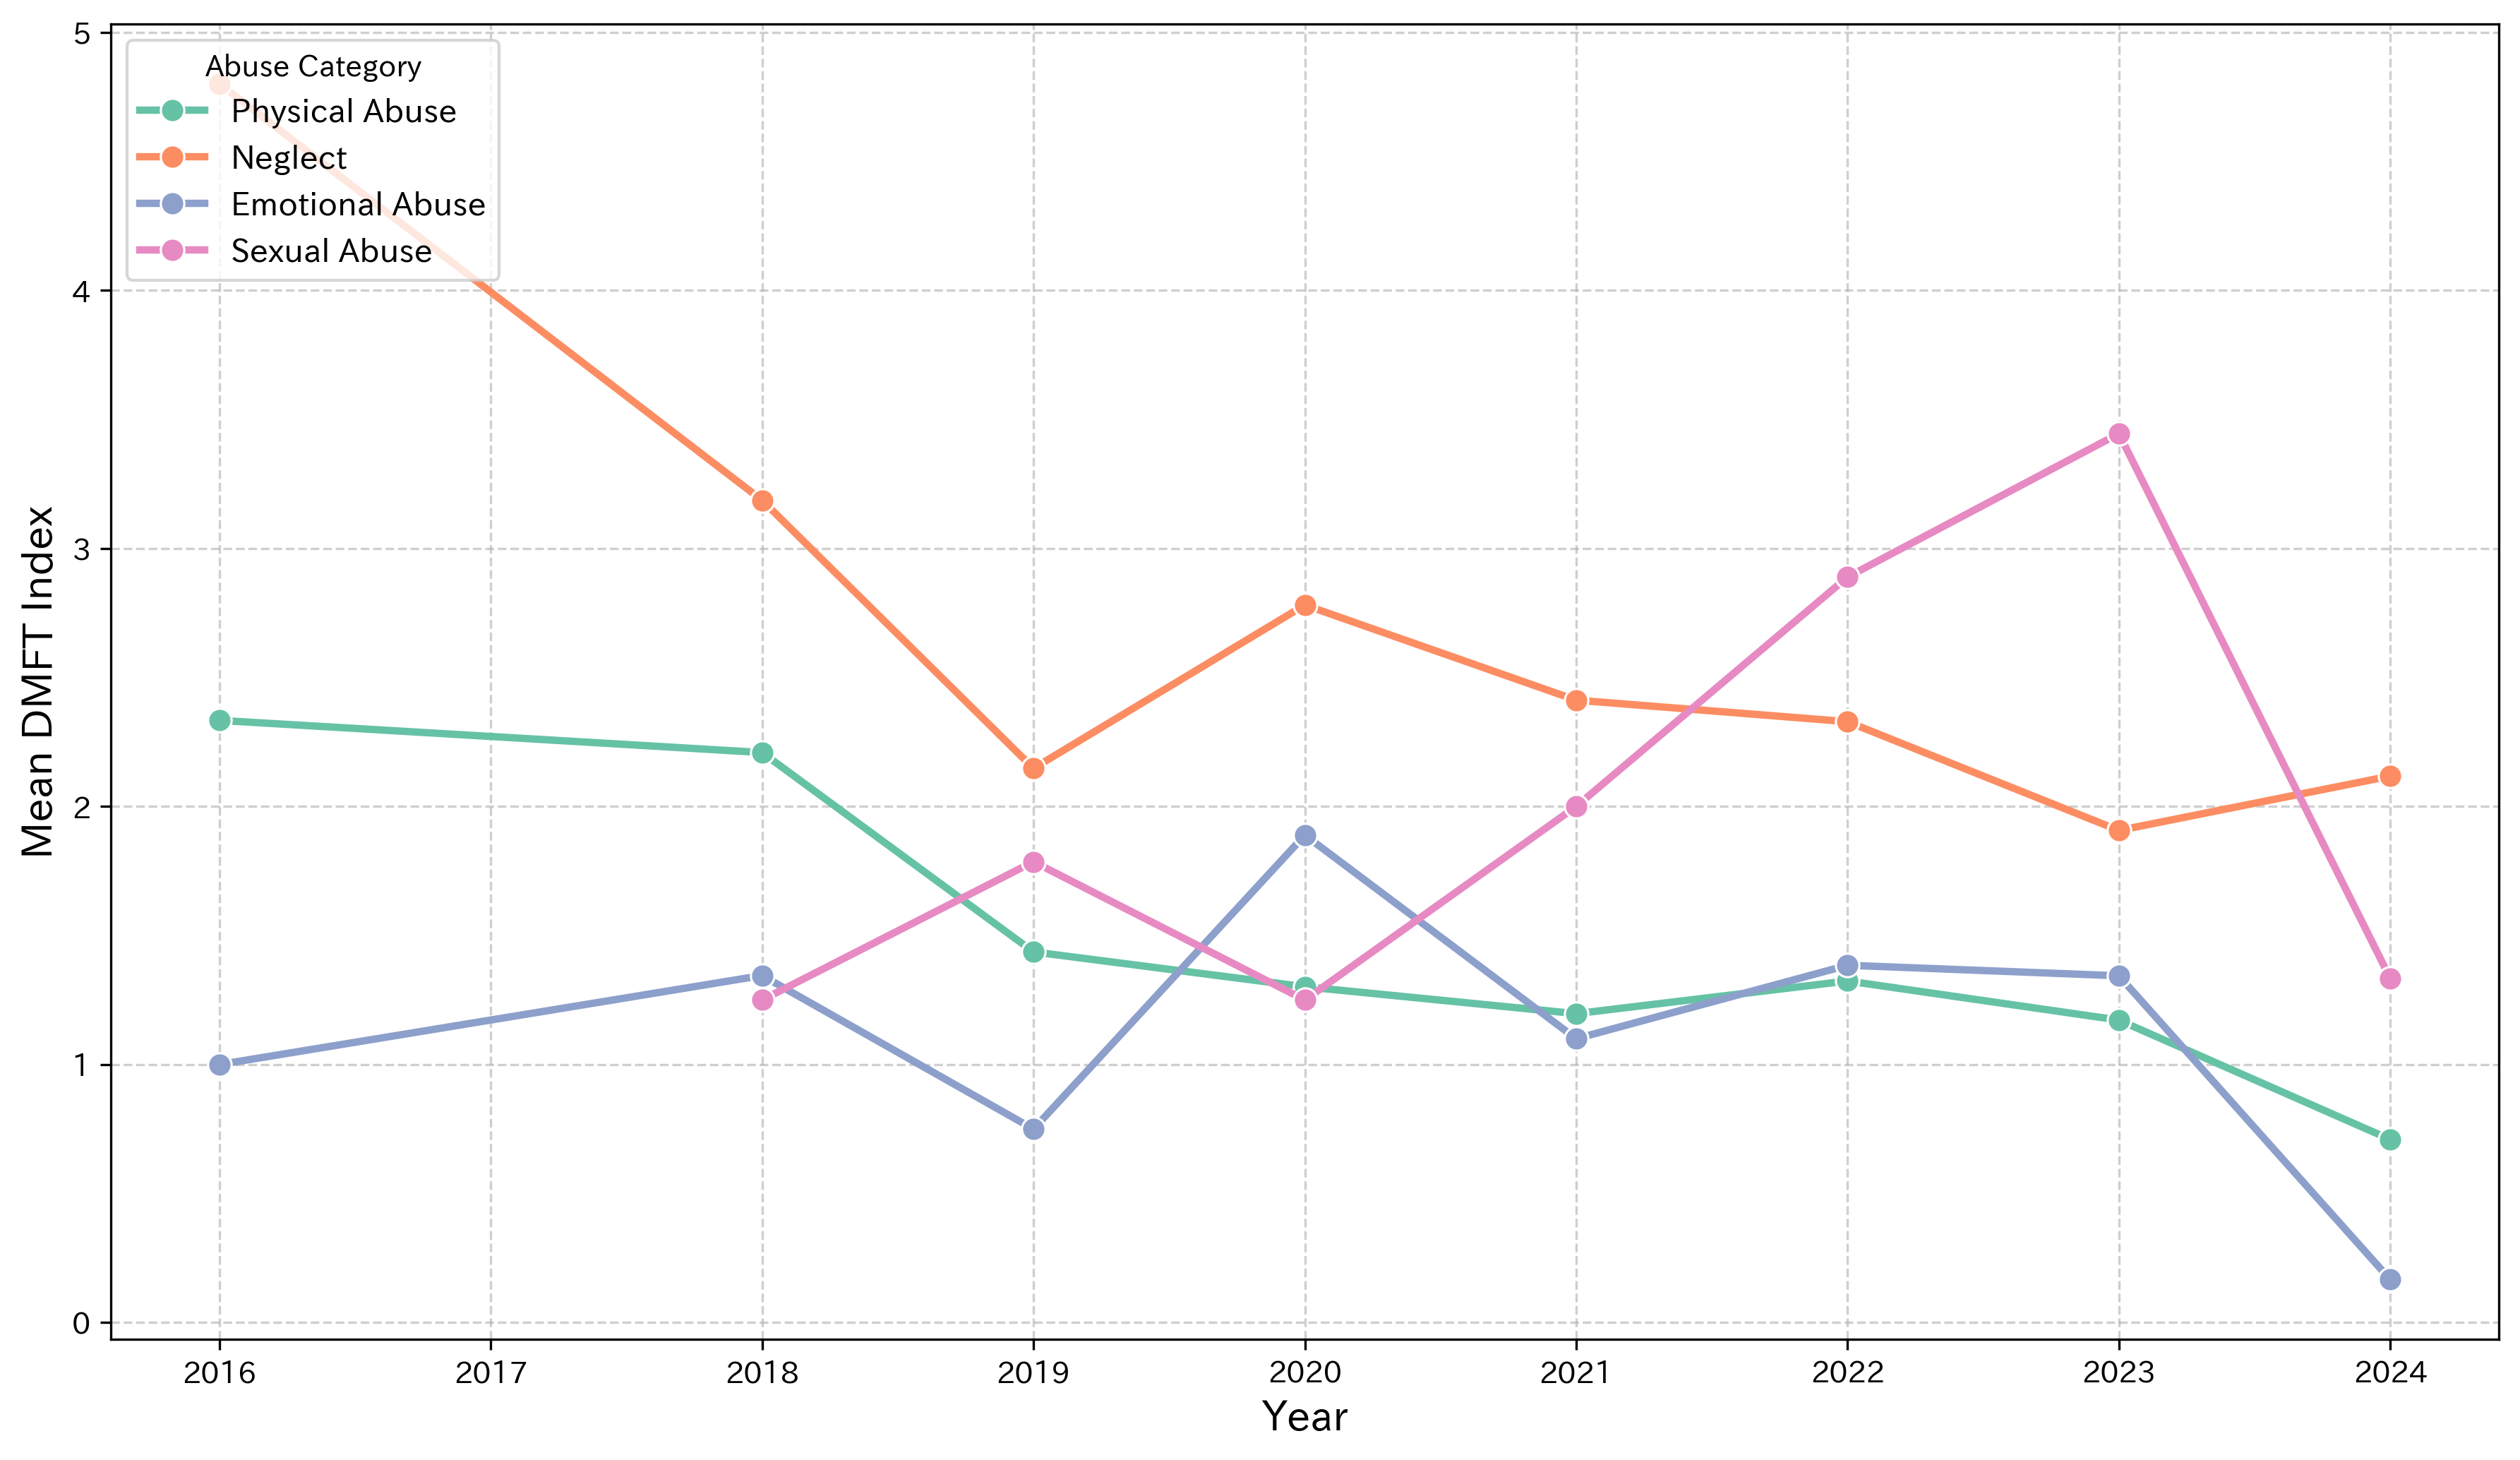


=== Sample Counts by Year and Abuse Category ===
abuse  Emotional Abuse  Neglect  Physical Abuse  Sexual Abuse
year                                                         
2016               3.0      5.0             9.0           NaN
2018              29.0     43.0            91.0           8.0
2019              32.0     61.0           110.0          14.0
2020              27.0     41.0            73.0           8.0
2021              20.0     51.0            71.0           9.0
2022              52.0     67.0           139.0           9.0
2023              32.0     43.0           122.0           9.0
2024               6.0     17.0            31.0           3.0


In [71]:
# Extract year from date
df_final['year'] = pd.to_datetime(df_final['date']).dt.year

# Aggregate by year and abuse category (calculate mean)
yearly_data = df_final.groupby(['year', 'abuse'])['DMFT_Index'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(12, 7), dpi=300)

abuse_order = ['Physical Abuse', 'Neglect', 'Emotional Abuse', 'Sexual Abuse']

sns.lineplot(
    data=yearly_data,
    x='year',
    y='mean',
    hue='abuse',
    hue_order=abuse_order, 
    marker='o',
    markersize=8,
    linewidth=2.5,
    palette='Set2'
)

# グラフの装飾
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Mean DMFT Index', fontsize=14, fontweight='bold')
plt.legend(title='Abuse Category', loc='upper left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-axis to show only integer years
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/lineplot_DMFT_mean_by_year.png", 
            dpi=300, bbox_inches='tight')
plt.show()

# Print sample counts per year
print("\n=== Sample Counts by Year and Abuse Category ===")
print(yearly_data.pivot(index='year', columns='abuse', values='count'))

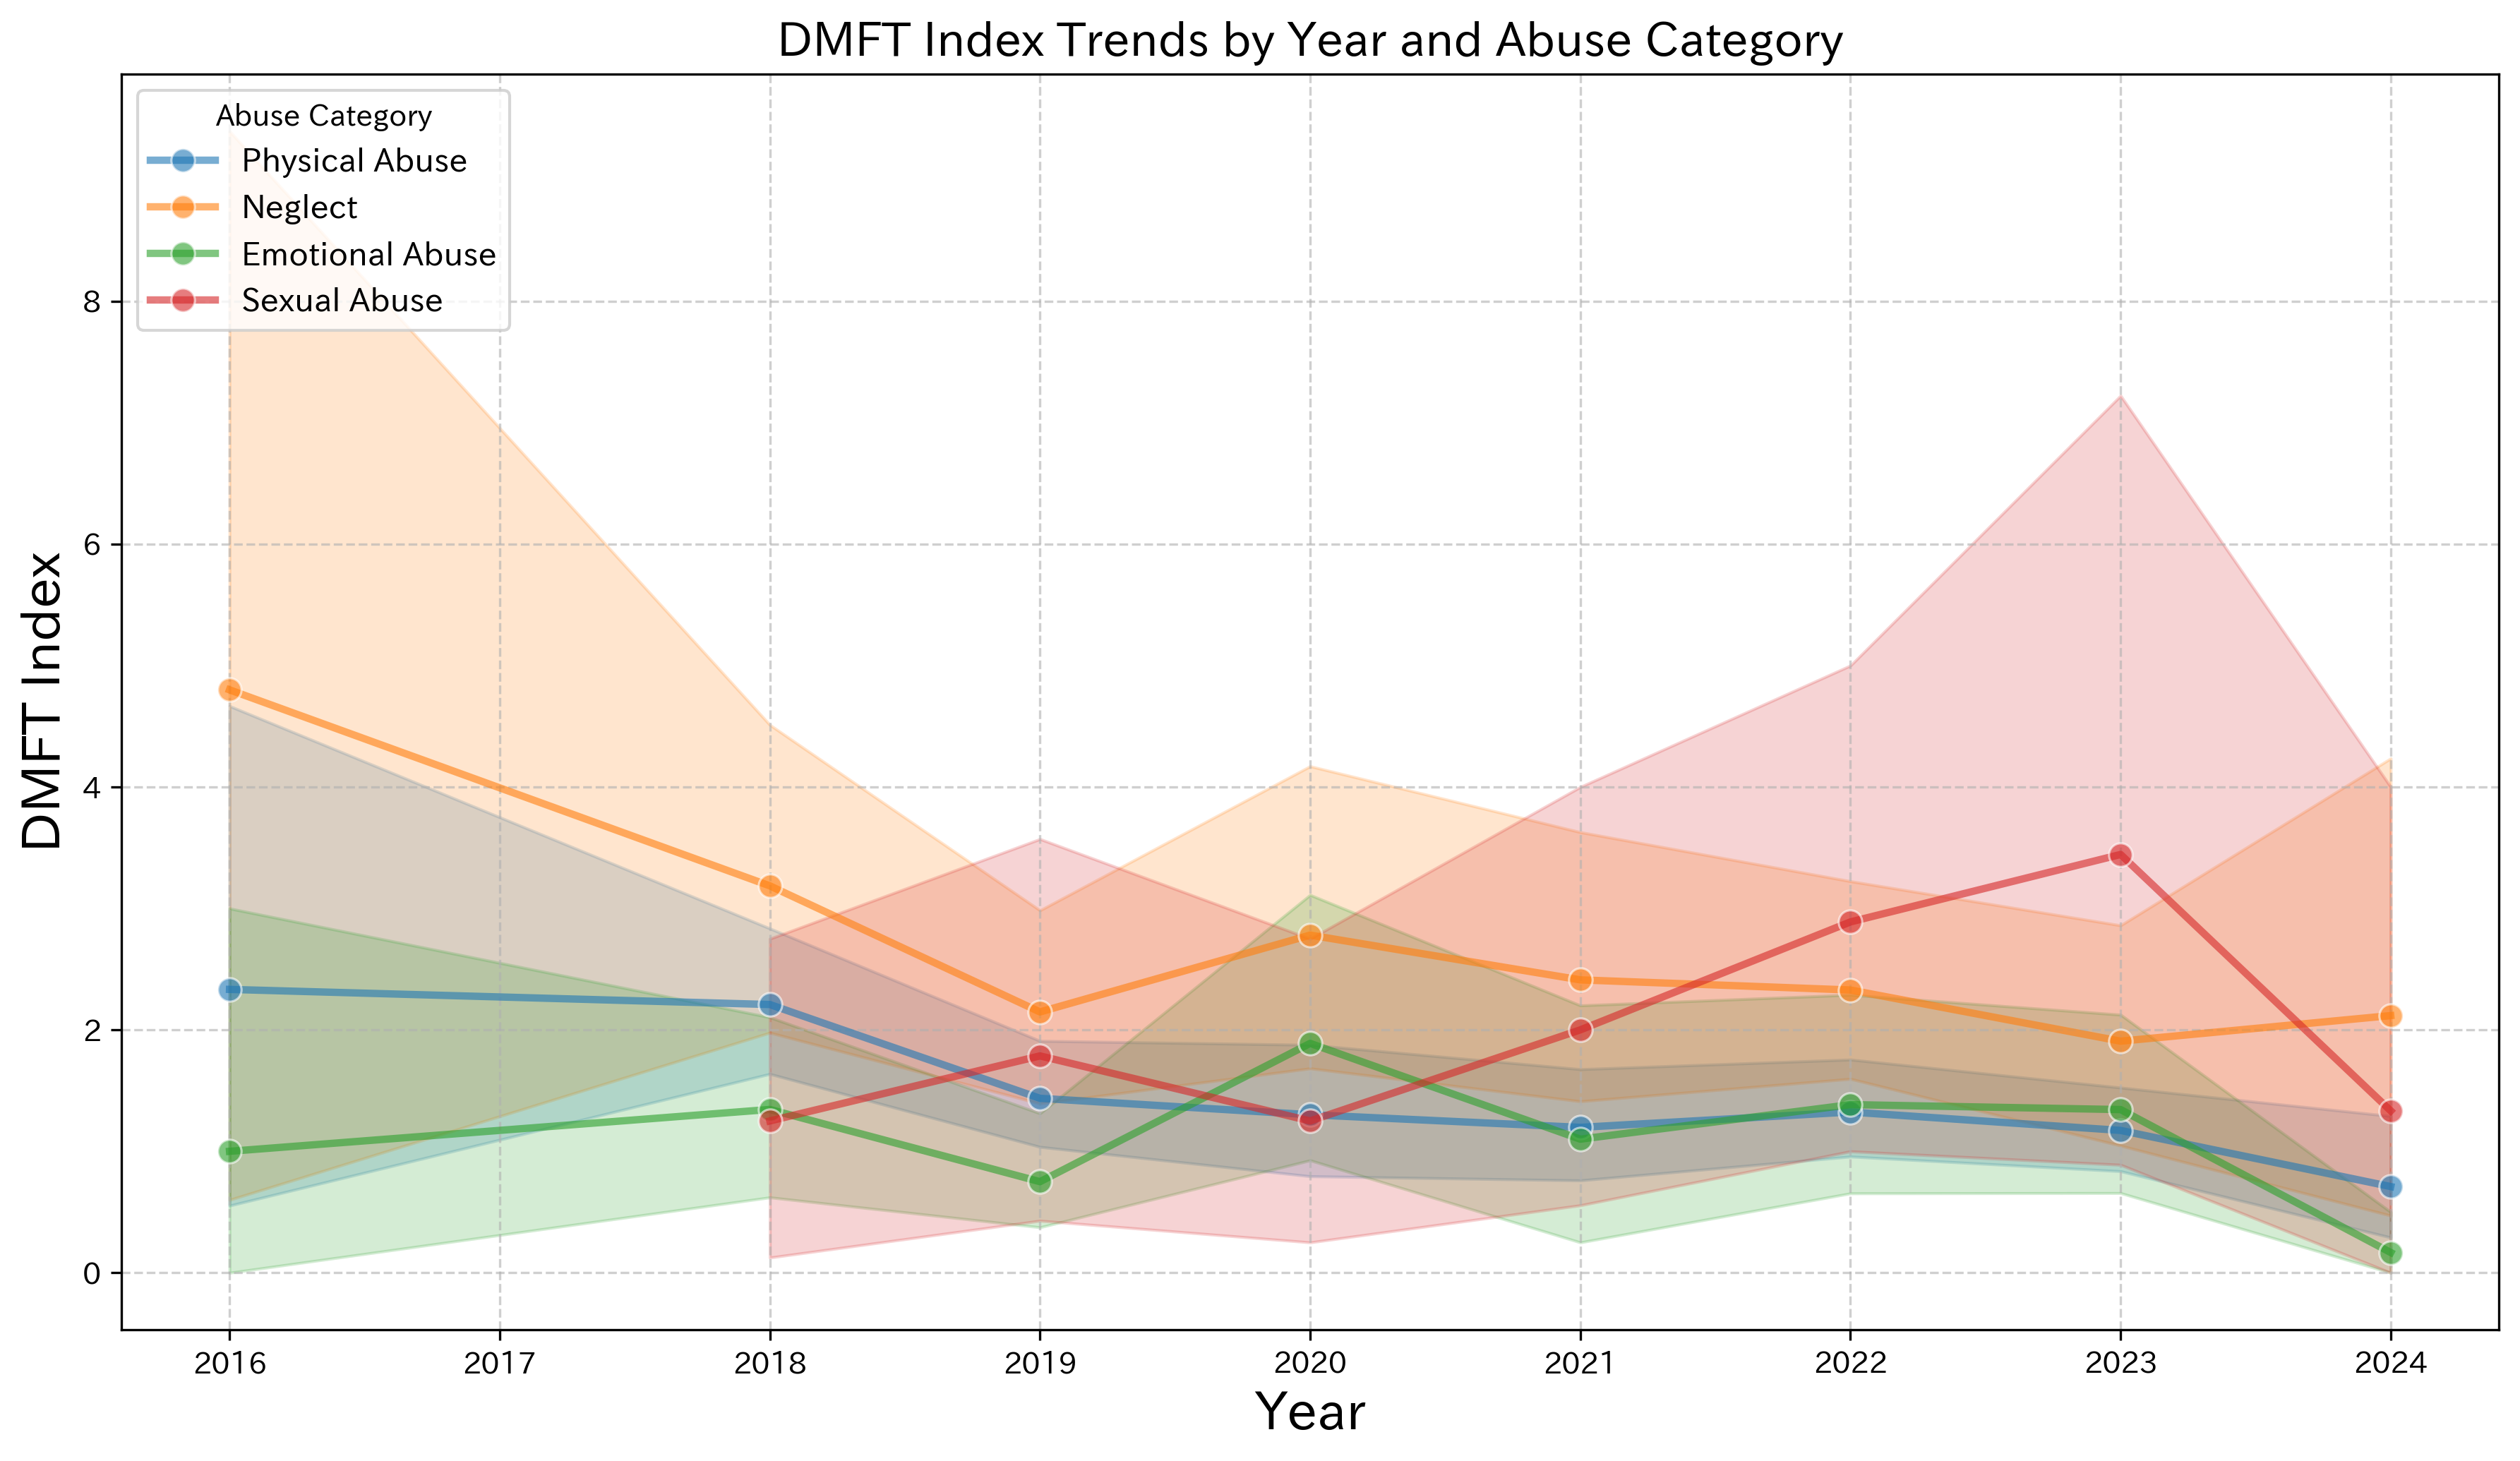

In [75]:
# Define abuse category order
abuse_order = ['Physical Abuse', 'Neglect', 'Emotional Abuse', 'Sexual Abuse']

# Extract year from date
df_final['year'] = pd.to_datetime(df_final['date']).dt.year

plt.figure(figsize=(12, 7), dpi=300)

sns.lineplot(
    data=df_final,
    x='year',
    y='DMFT_Index',
    hue='abuse',
    hue_order=abuse_order,  # ← ADD THIS
    marker='o',
    markersize=8,
    linewidth=2.5,
    err_style='band',
    errorbar='ci',
    alpha=0.6
)

# グラフの装飾
xy_lableSize = 18
plt.xlabel('Year', fontsize=xy_lableSize, fontweight='bold')
plt.ylabel('DMFT Index', fontsize=xy_lableSize, fontweight='bold')
plt.title('DMFT Index Trends by Year and Abuse Category', fontsize=16, fontweight='bold')
plt.legend(title='Abuse Category', loc='upper left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-axis to show only integer years
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/lineplot_DMFT_by_year_CI.png", 
            dpi=300, bbox_inches='tight')
plt.show()

### 虐待別

In [ ]:
# df_physical = df_final[df_final['abuse'] == "Physical Abuse"]
# df_neglect = df_final[df_final['abuse'] == "Neglect"]
# df_emotional = df_final[df_final['abuse'] == "Emotional Abuse"]
# df_sexual = df_final[df_final['abuse'] == "Sexual Abuse"]

#### Function: per age

In [119]:
# variable_panel: パネル別の変数名
# variable_y: y軸の変数名
# y_label: y軸のラベル
# title: タイトル
# save_path: 保存先
# panel_name: パネル名

def plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name):
    # Define abuse category order
    abuse_order = ['Physical Abuse', 'Neglect', 'Emotional Abuse', 'Sexual Abuse']

    # Create FacetGrid
    g = sns.FacetGrid(
        df_final, 
        col=variable_panel,
        col_wrap=4,
        height=4, 
        aspect=1.2,
        sharex=False,
        sharey=True
    )

    # Map boxplot with hue=x and legend=False
    g.map_dataframe(
        sns.boxplot,
        x='abuse',
        y=variable_y,
        hue='abuse',
        palette='Set2',
        order=abuse_order,
        legend=False
    )

    # Add mean lines and customize each subplot
    for ax, age in zip(g.axes.flat, sorted(df_final[variable_panel].unique())):
        age_data = df_final[df_final[variable_panel] == age]
        
        # Add mean lines
        for i, abuse in enumerate(abuse_order):
            subset = age_data[age_data['abuse'] == abuse][variable_y]
            
            if len(subset) > 0:
                mean_val = subset.mean()
                
                ax.hlines(mean_val, i - 0.4, i + 0.4, 
                        colors='red', linestyles='--', linewidth=2, zorder=10)
                
                ax.text(i + 0.42, mean_val, f'{mean_val:.2f}', 
                    fontsize=8, color='red', va='center', fontweight='bold')
        
        # Update x-tick labels with sample sizes
        new_labels = []
        for abuse in abuse_order:
            n_samples = len(age_data[age_data['abuse'] == abuse])
            short_name = abuse.replace(' Abuse', '')
            new_labels.append(f'{short_name}\n(n={n_samples})')
        
        # Set tick positions first, then labels
        ax.set_xticks(range(len(abuse_order)))
        ax.set_xticklabels(new_labels, fontsize=12)
        
        # Add total sample size to title
        n_total = len(age_data)
        ax.set_title(f'{panel_name}: {age} (n = {n_total})', fontsize=14, fontweight='bold')
        
        # Set y-axis to show only integers
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        ax.tick_params(axis='x', rotation=0, labelsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    g.set_axis_labels('Abuse Category', y_label, fontsize=14)
    g.fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

#### panel plot by Age

In [110]:
variable_panel = 'age_year'
panel_name = 'Age'

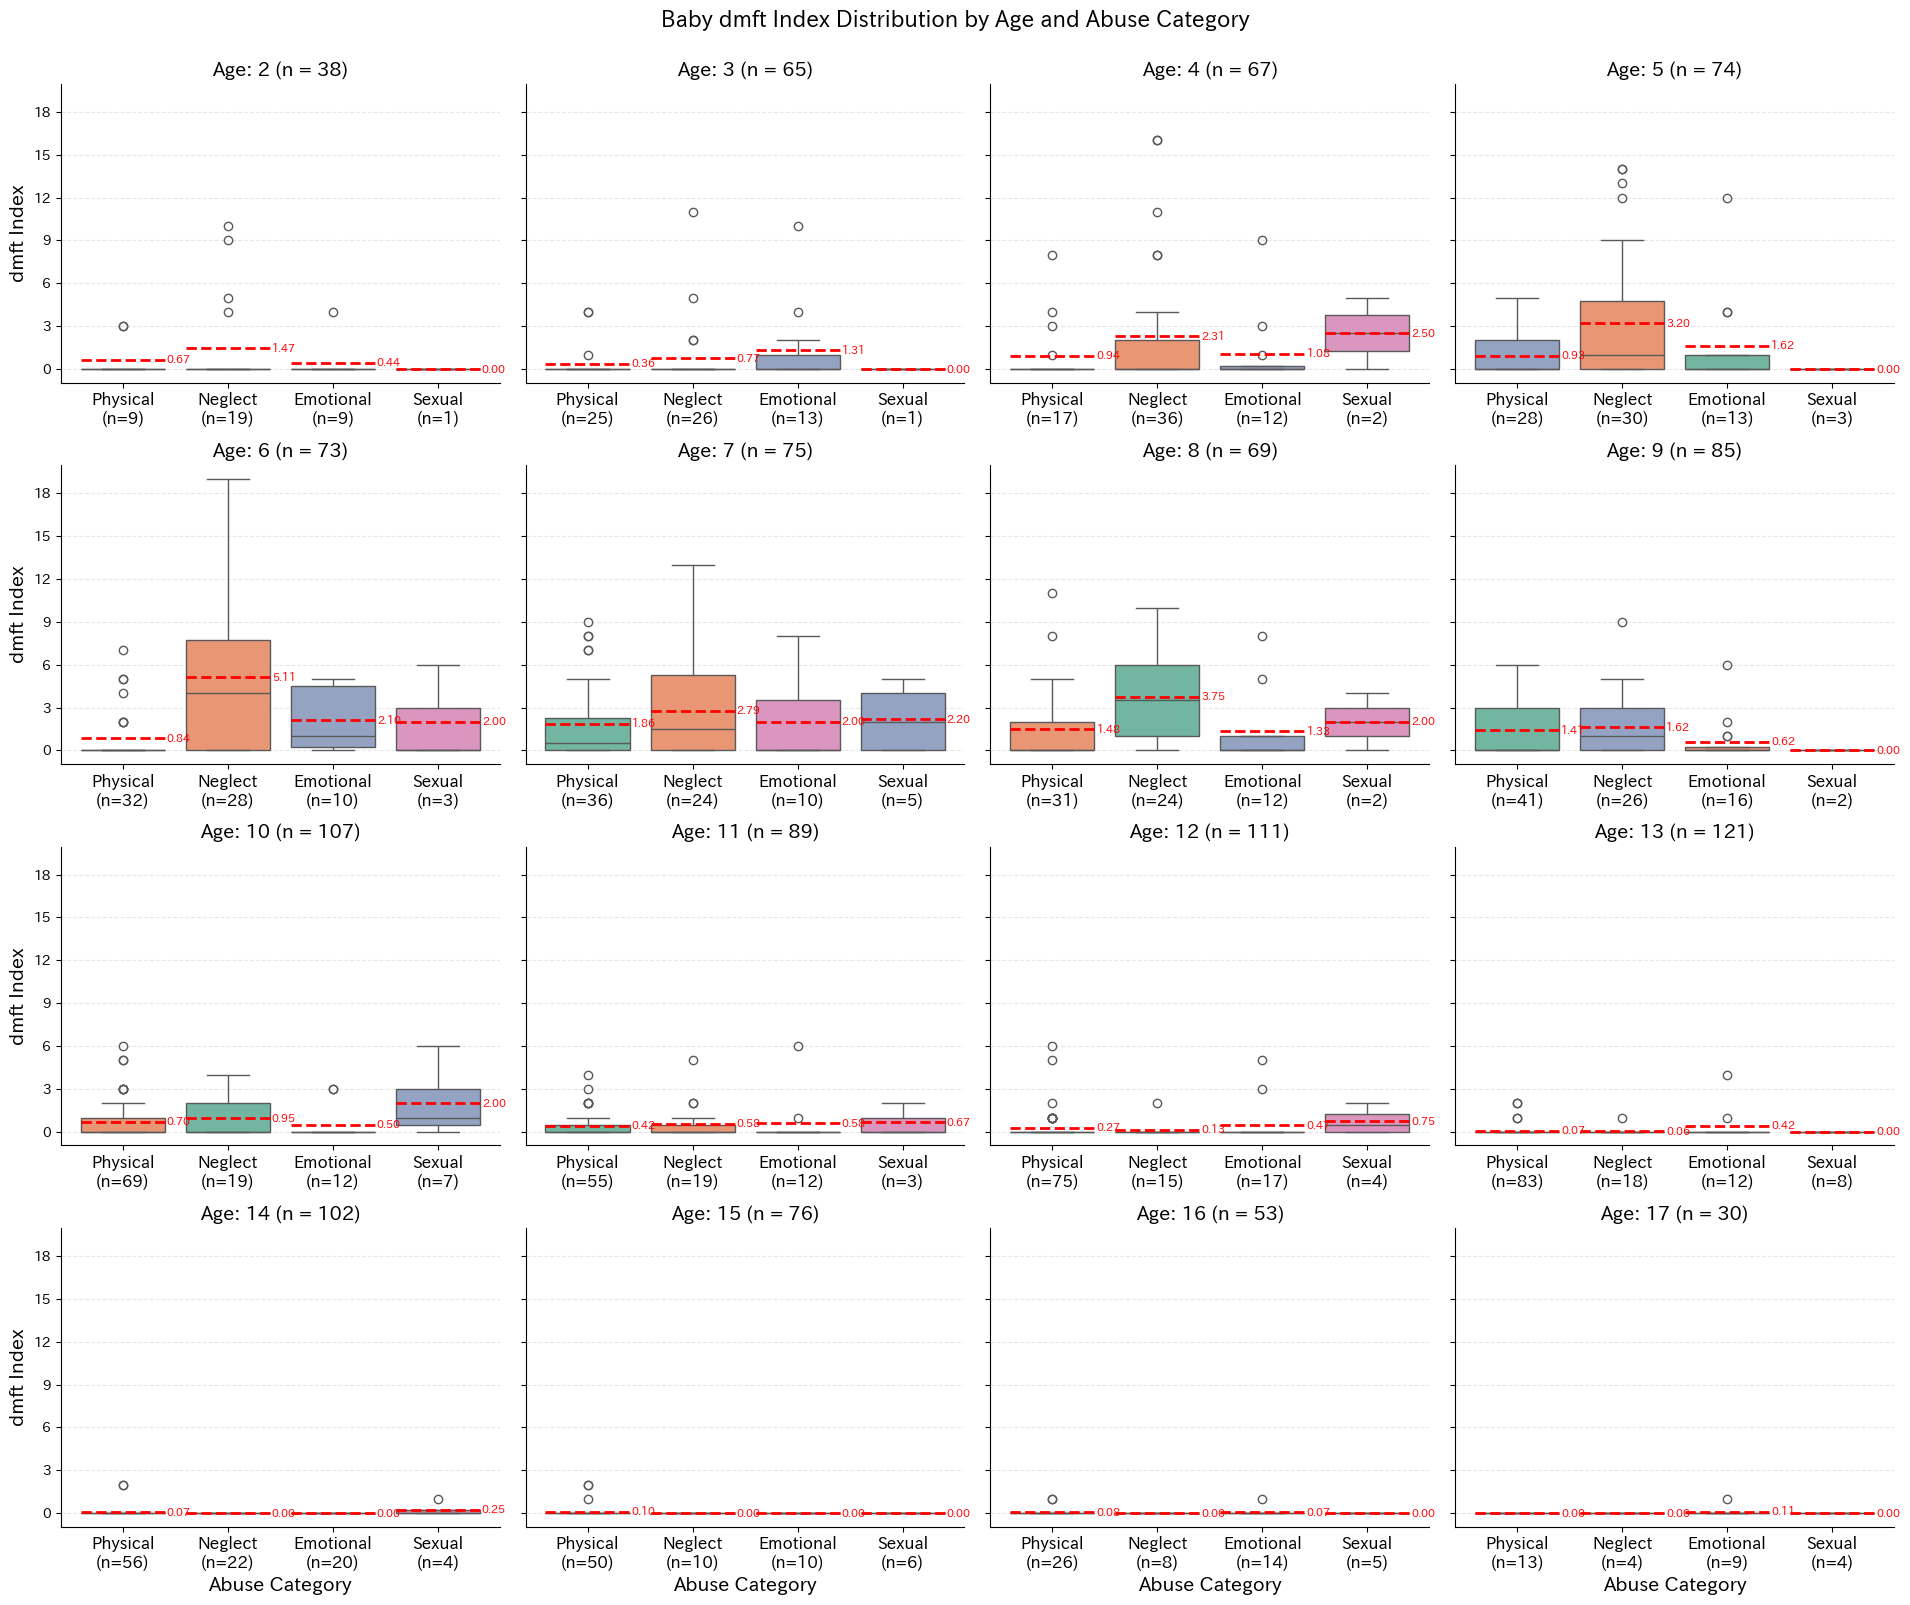

In [111]:
# Baby dmft
variable_y = 'Baby_DMFT'
y_label = 'dmft Index'
title = 'Baby dmft Index Distribution by Age and Abuse Category'
save_path = '/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_baby_dmft_Age_facetgrid.png'
plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

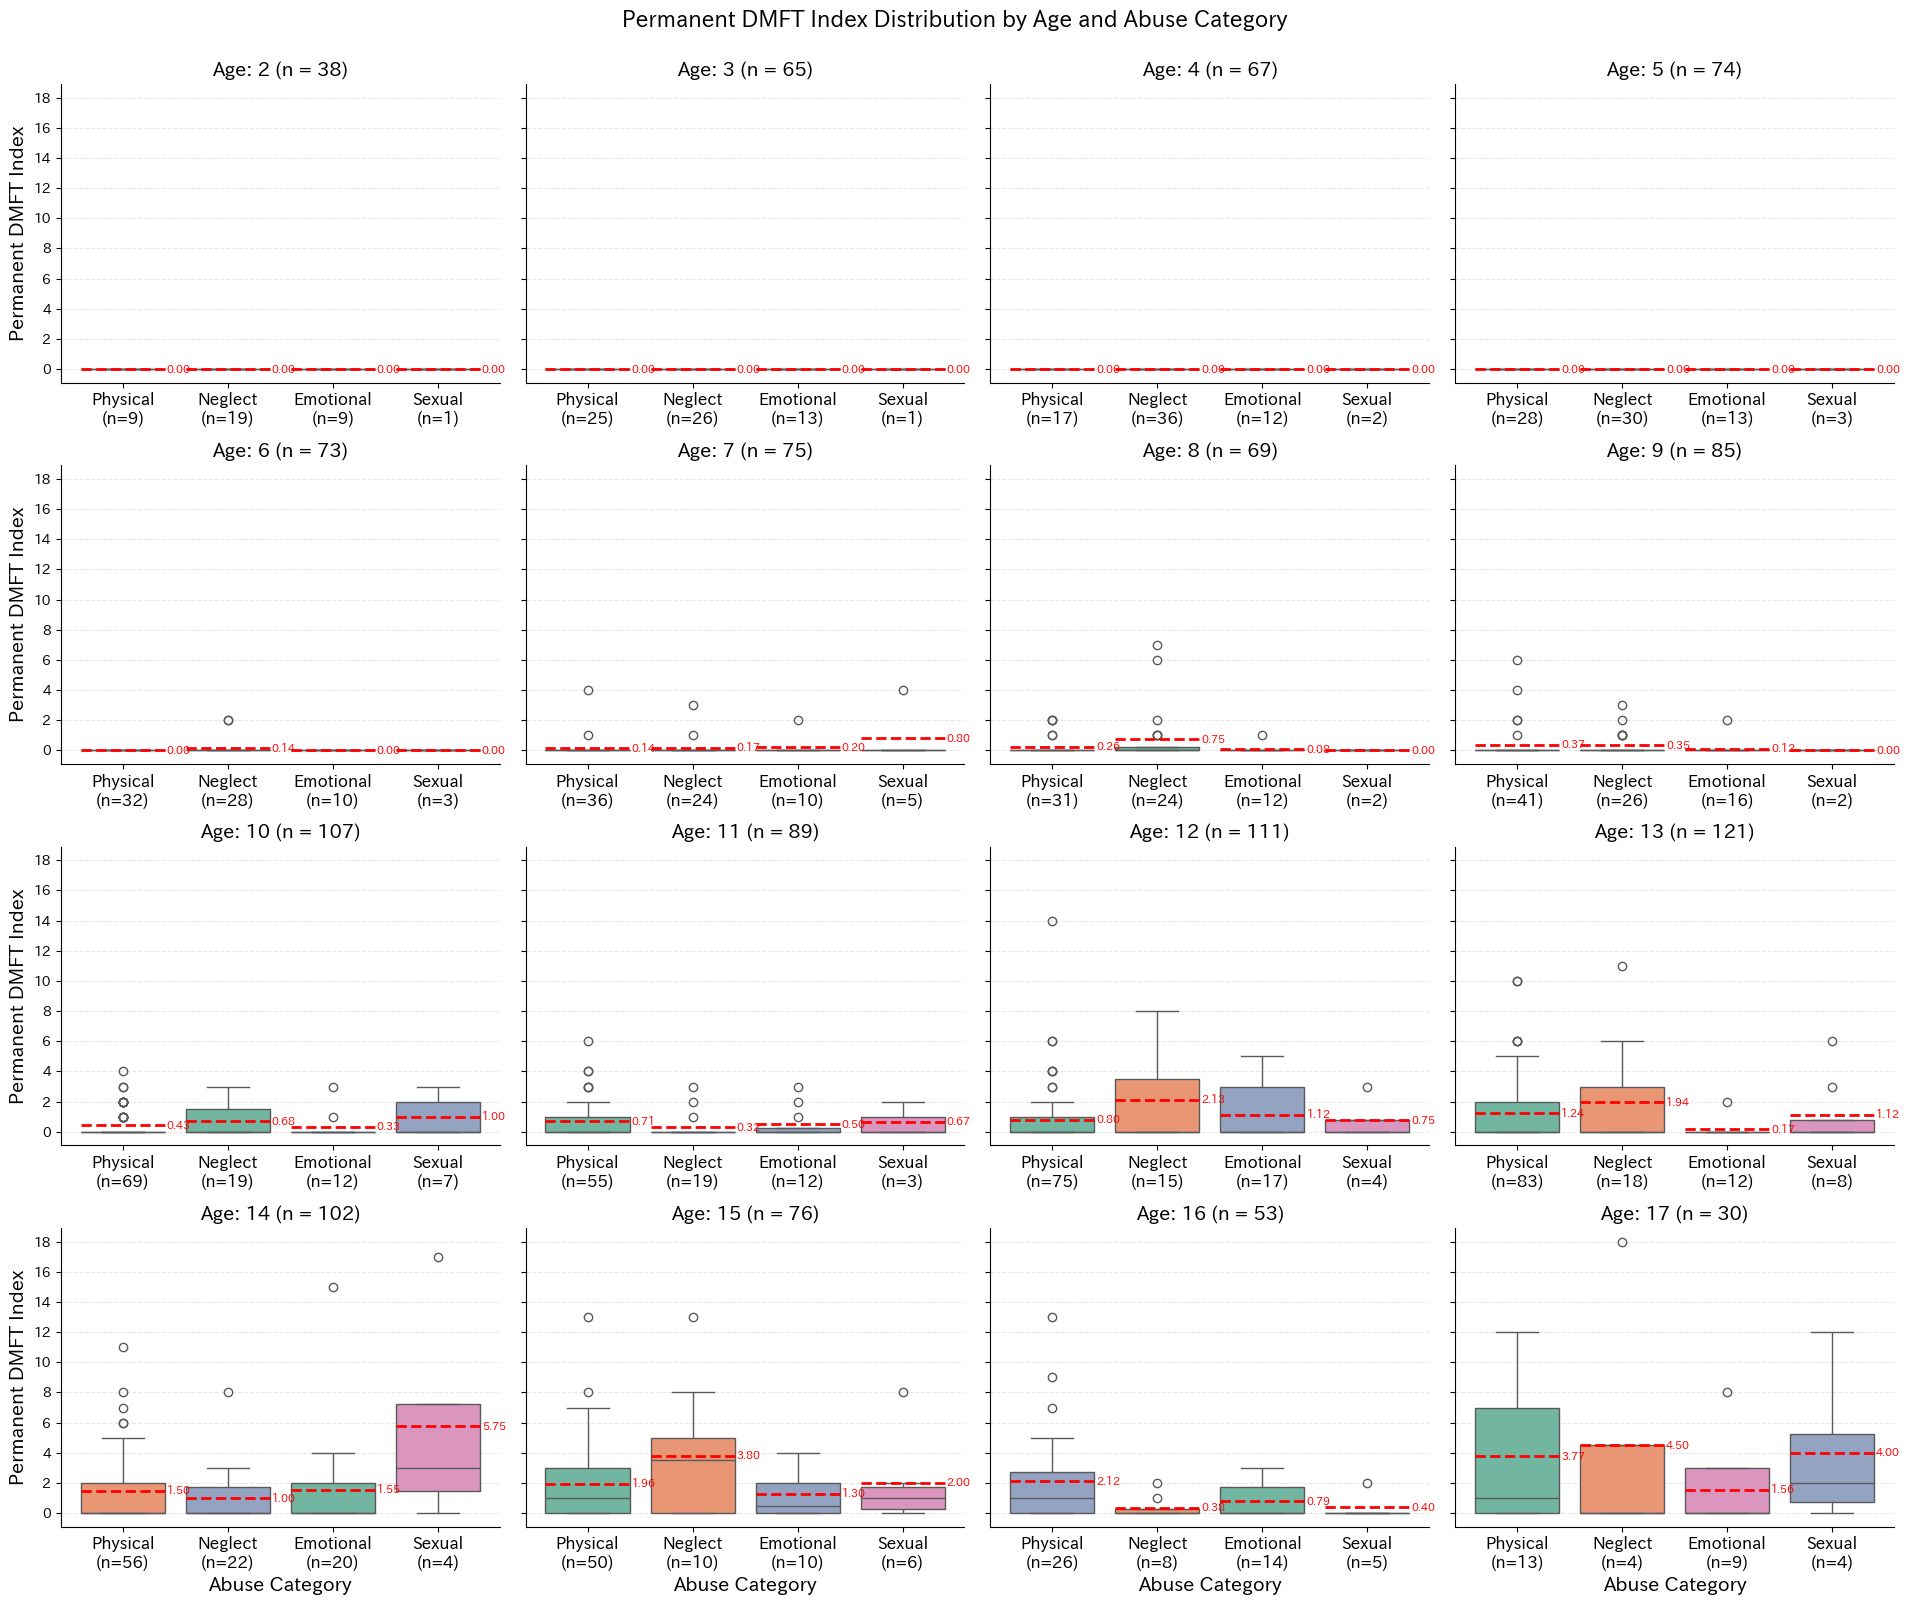

In [112]:
# Permanent DMFT
variable_y = 'Perm_DMFT'
y_label = 'Permanent DMFT Index'
title = 'Permanent DMFT Index Distribution by Age and Abuse Category'
save_path = '/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_perm_dmft_Age_facetgrid.png'
plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

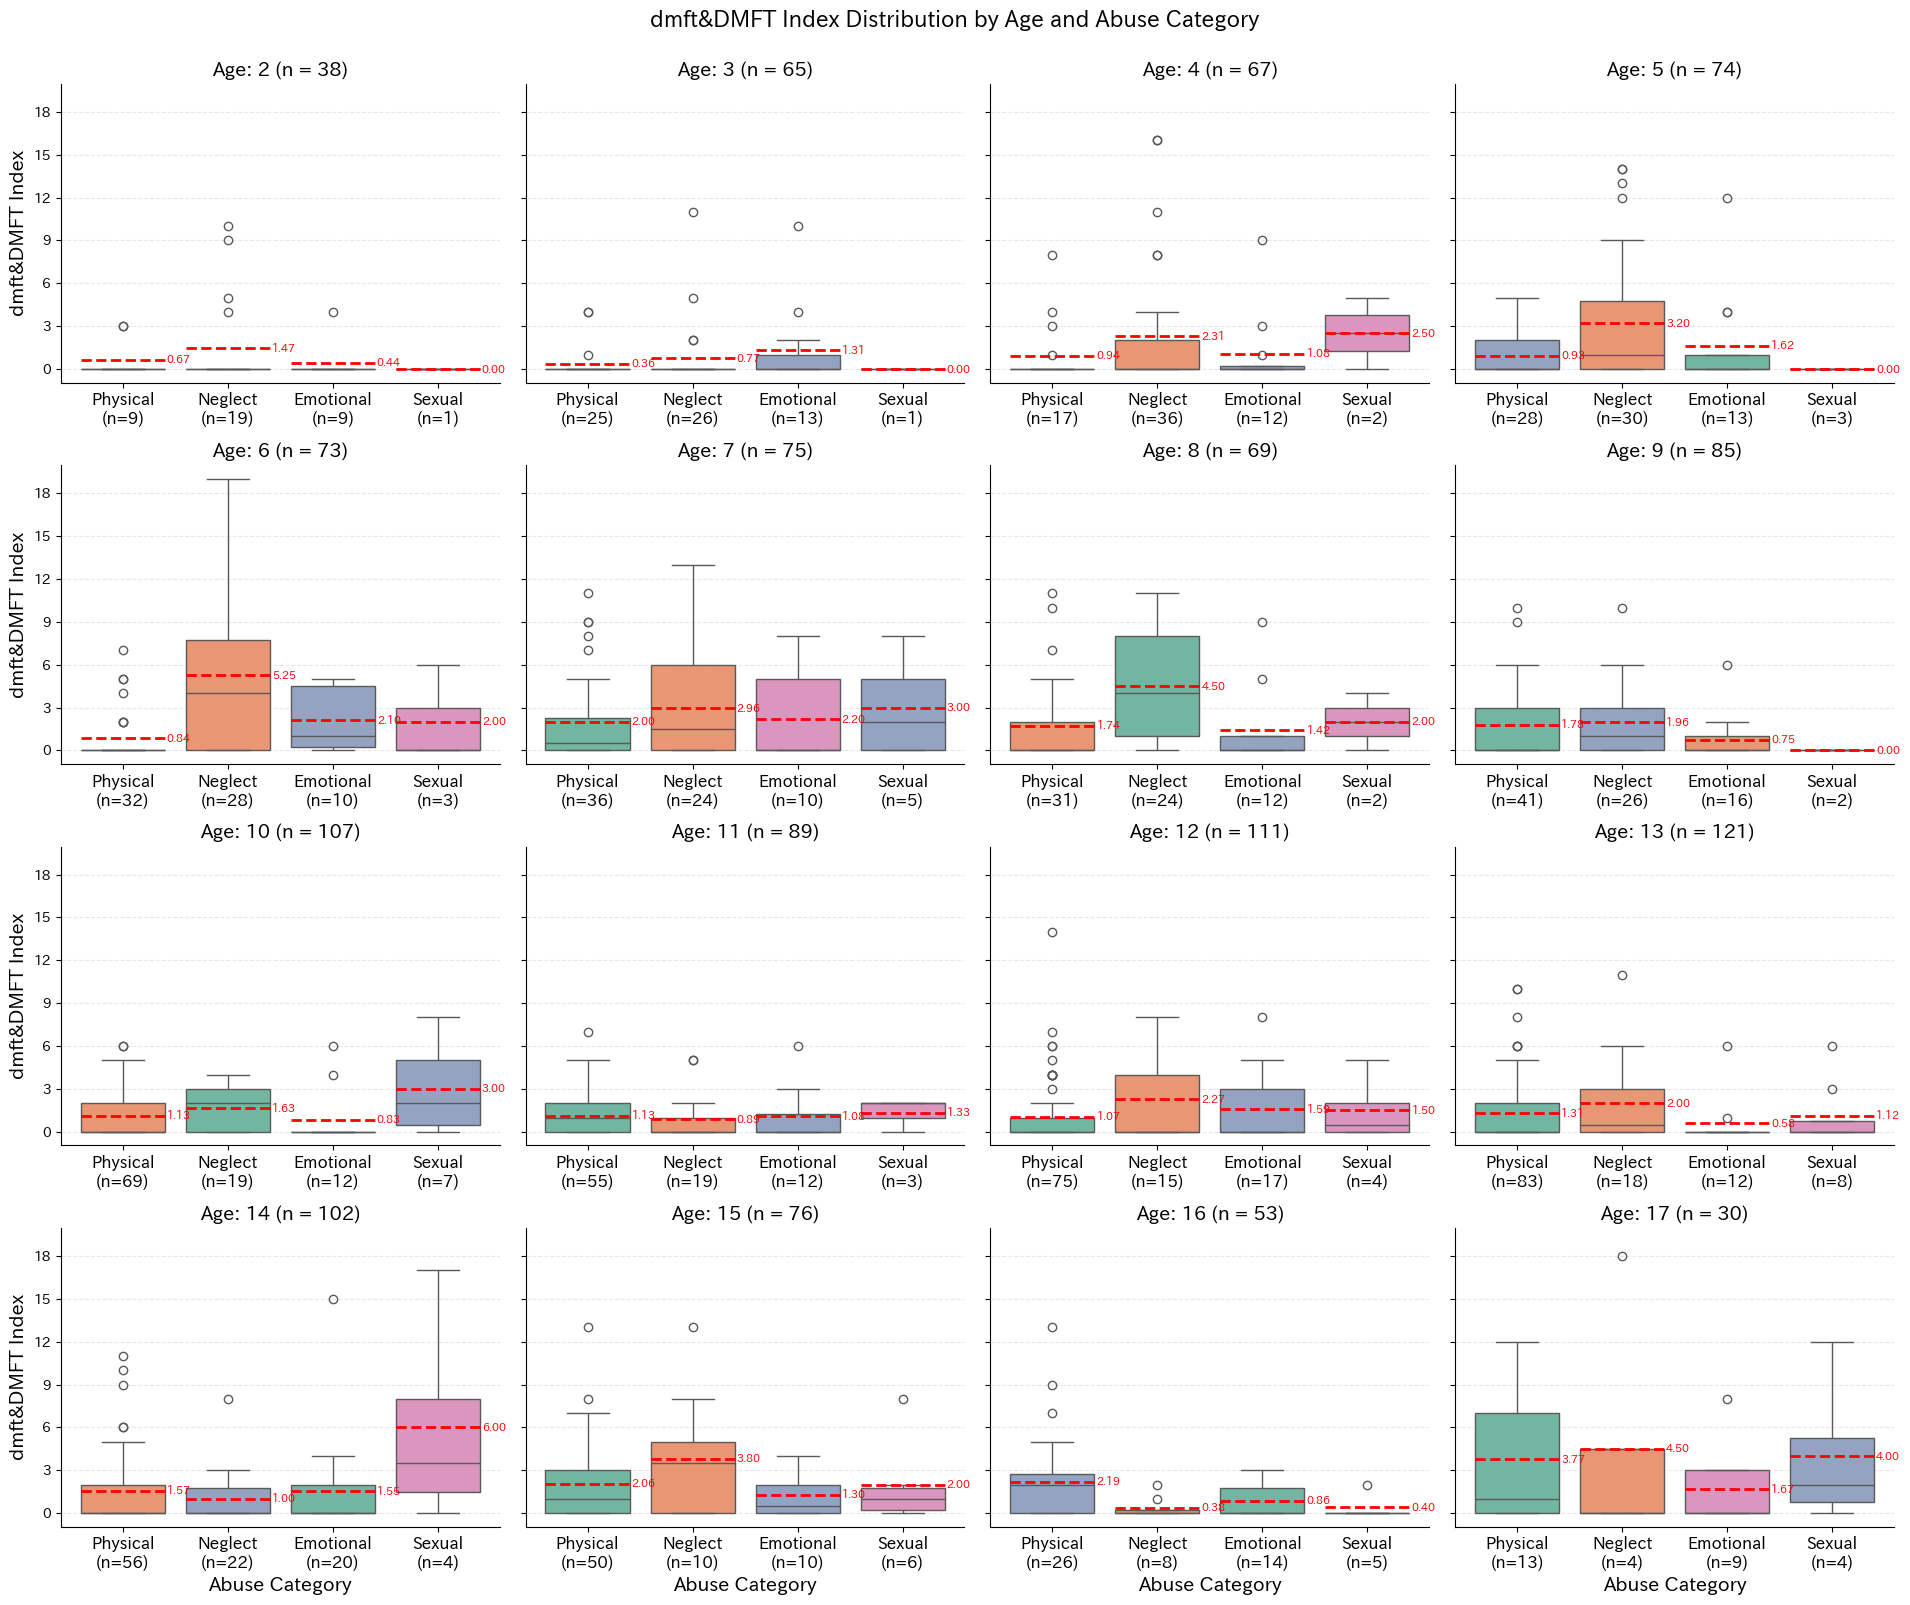

In [113]:
# dmft&DMFT
variable_y = 'DMFT_Index'
y_label = 'dmft&DMFT Index'
title = 'dmft&DMFT Index Distribution by Age and Abuse Category'
save_path = '/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_dmft_DMFT_Age_facetgrid.png'
plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

Processing: age_year
Processing: age
Processing: Perm_D
Processing: Perm_M
Processing: Perm_F
Processing: Baby_d
Processing: Baby_m
Processing: Baby_f
Processing: Perm_DMFT
Processing: Baby_DMFT
Processing: Perm_DMFT_C0
Processing: Baby_DMFT_C0
Processing: DMFT_Index
Processing: DMFT_C0
Processing: Present_Teeth
Processing: Present_Perm_Teeth
Processing: Present_Baby_Teeth
Processing: Healthy_Rate
Processing: C0_Count
Processing: Care_Index
Processing: Trauma_Count
Processing: RDT_Count
Processing: UTN_Score

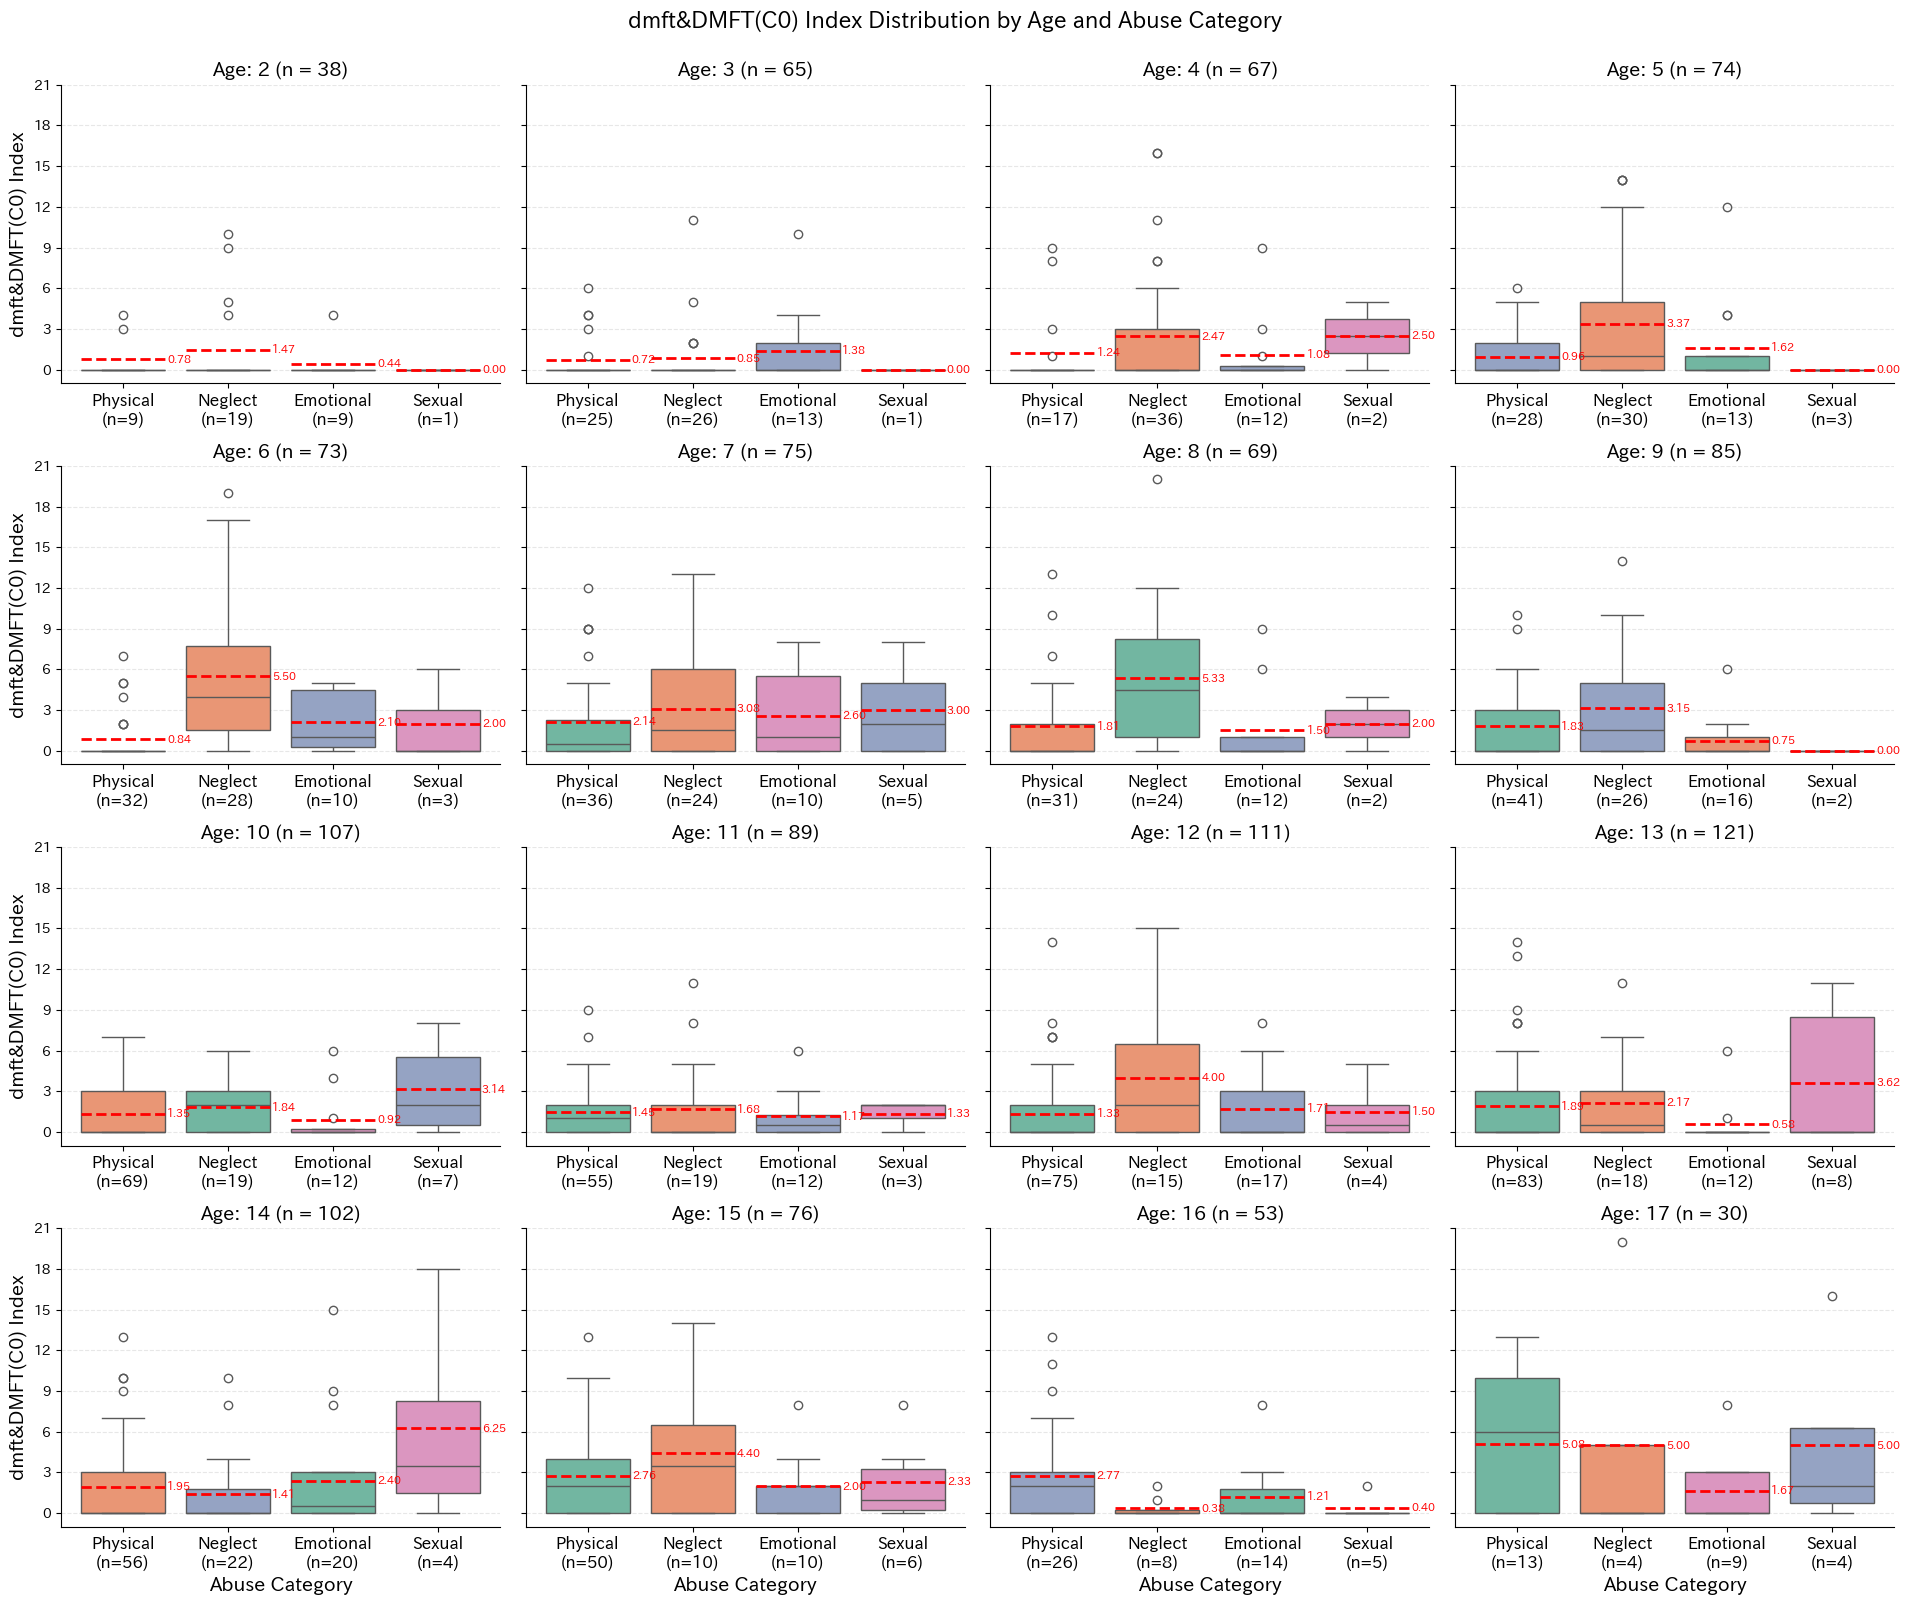

In [114]:
# dmft&DMFT_C0
variable_y = 'DMFT_C0'
y_label = 'dmft&DMFT(C0) Index'
title = 'dmft&DMFT(C0) Index Distribution by Age and Abuse Category'
save_path = '/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_dmft_DMFT_C0_Age_facetgrid.png'
plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

In [115]:
columns_to_analyze_facetgrid = ['Perm_D', 'Perm_M', 'Perm_F', 'Perm_DMFT', 'Perm_DMFT_C0', 
                      'Baby_d', 'Baby_m', 'Baby_f', 'Baby_DMFT', 'Baby_DMFT_C0',
                      'DMFT_Index', 'DMFT_C0','Present_Teeth', 'Present_Perm_Teeth', 'Present_Baby_Teeth', 
                      'Healthy_Rate', 'C0_Count', 'Care_Index', 
                      'Trauma_Count', 'RDT_Count', 'UTN_Score']

In [120]:
for i in columns_to_analyze_facetgrid:
    variable_panel = 'age_year'
    panel_name = 'Age'
    # dmft&DMFT_C0
    variable_y = i  
    y_label = f'{i} Index'
    title = f'{i} Index Distribution by Age and Abuse Category'
    save_path = f'/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_{i}_Age_facetgrid.png'
    plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [121]:
for i in columns_to_analyze_facetgrid:
    variable_panel = 'sex'
    panel_name = 'Sex'
    # dmft&DMFT_C0
    variable_y = i  
    y_label = f'{i} Index'
    title = f'{i} Index Distribution by Age and Abuse Category'
    save_path = f'/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/figure/panel_{i}_Sex_facetgrid.png'
    plot_facetgrid(df_final, variable_panel, variable_y, y_label, title, save_path,panel_name)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
